![](https://www.winet.dcc.ufmg.br/wp-content/uploads/2019/09/dcc.gif)

## Universidade Federal de Minas Gerais 
## ICEX - Departamento de Ciência de Computação

### Trabalho de Aprendizado de Máquina 
 
##### Professor Dr. Adriano Veloso 
###### Aluno: Matheus Vinícius Freitas Oliveira dos Santos - 2020027172

### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from copy import copy
import statistics as sts
import scipy.stats as st

#!pip install pandas
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE


### Carregamento e pré-processamento dos dados

Abaixo é encontrado o código de carregamento e pré-processamento do dado. Inicialmente, o dado é carregado em formato 'dataframe' da biblioteca pandas. Depois, é separado em caracteristicas e, por último, dividido em 5 folds, para ser avaliado através da validação cruzada.

In [2]:
# importação dos dados
data = pd.read_csv("data_tp1", header=None)
count_nan_in_df = data.isnull().sum().sum()
print(f'Quantidade de valores nan: {count_nan_in_df}')
print(f'shape do dado: {data.shape}')
print(f'Valor máximo contido nas samples do dado: {data.values.max()}')
# separação entre o vetor de features do número e a label que ele representa, respectivamente 
X , Y = data.values[:5000, 1:], data.values[:, 0]
classes = list(set(Y))
print(f'Lista de todas as classes: {classes}')
print(f'Shape do vetor de features X: {X.shape}')
print(f'Shape do vetor Y associado a cada sample: {Y.shape}')
#normalização do vetor de features
X = X/255
#divisão em 5 partes de treino e teste, ou seja, 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train, test in kf.split(X):
    print("TRAIN:", train.shape, "TEST:", test.shape)

Quantidade de valores nan: 0
shape do dado: (5000, 785)
Valor máximo contido nas samples do dado: 255
Lista de todas as classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Shape do vetor de features X: (5000, 784)
Shape do vetor Y associado a cada sample: (5000,)
TRAIN: (4000,) TEST: (1000,)
TRAIN: (4000,) TEST: (1000,)
TRAIN: (4000,) TEST: (1000,)
TRAIN: (4000,) TEST: (1000,)
TRAIN: (4000,) TEST: (1000,)


### Plot e visualização dos dados

Foi reduzida a dimensionalidade das características utilizando TSNE e plotado em 2D e 3D, com o objetivo de visualizar os dados nessas dimensões. Dessa forma, percebe-se que são divisíveis nessas dimensões.

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fce4022f0d0>
Traceback (most recent call last):
  File "/home/matheus/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/matheus/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/matheus/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/matheus/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>

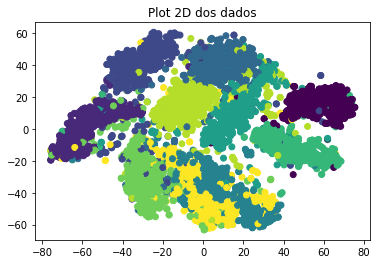

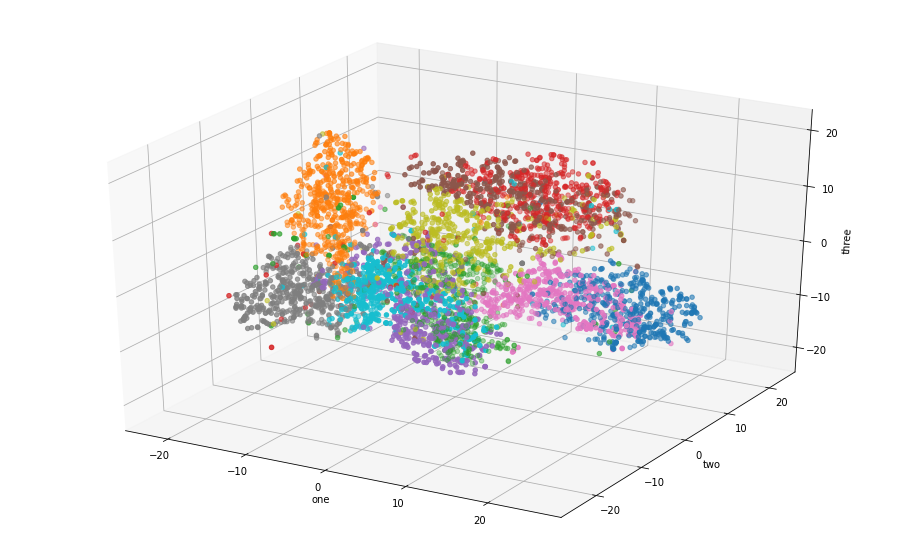

In [3]:
#calculando TSNE para 2 dimensões e para 3 dimensões
#####Pode demorar um pouco
labelencoder = LabelEncoder()
y_transf = labelencoder.fit_transform(Y)
ts_d2 = TSNE(n_components=2).fit_transform(X)
ts_d3 = TSNE(n_components=3).fit_transform(X)
plt.scatter(*zip(*ts_d2[:,:2]), c = y_transf)
plt.title('Plot 2D dos dados')
plt.show()

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(xs=ts_d3[:,0], ys=ts_d3[:,1], zs=ts_d3[:,2], c=y_transf, cmap='tab10')
ax.set_xlabel('one')
ax.set_ylabel('two')
ax.set_zlabel('three')
plt.show()

### Execução e análise dos algoritmos
A partir dessa célula serão apresentadas as execuções e as análises dos algoritmos, com objetivo de avaliar o desempenho de cada hiperparâmetro.

Serão apresentados gráficos com base em acuracia, precisão e revocação. Abaixo estão listadas essas métricas com explicação sobre o que representão e como fazer a leitura.

- Acuracia - Acuracia é a métrica relacionada a quantidade de acertos. Essa métrica é dada pela razão da quantidade de acertos pela quantidade total de predições. 
- Precisão - Tem a ver com a dispersão das respostas do classificador em relação aos dados preditos. Se a dispersão for menor, indica que o classificador está mais 'certo' de suas respostas. É dado pela razão entre a quantidade de vezes que foi predito verdade pela quantidade de vezes que foi predito verdade corretamente. 
- Revocação - Tem a ver com a taxa de acertos na classe positivo. É dado pela razão entre os valores classificados como positivos no teste pela quantidade de exemplos que são de fato positivos.

Todas as métricas anteriores vão de 0 a 1 ou de 0% a 100%, e quanto maior o valor, melhor é o classificado.

OBS.: todos os testes abaixo foram realizados para um valor fixo de épocas, a saber, 100 épocas.

In [4]:
#Listas que serão usadas na conclusão. Serão salvos os melhores resultados de cada modelo.
algorithms = ['SGD', 'GD', 'Mini-batch SGD']
acc_conc, pre_conc, rec_conc, roc_conc = [], [], [], []
# hiperparâmetros
ratings, units_hidden_layers, epochs, mini_batch = [0.5, 1, 10], [25, 50, 100], 100, [10, 50] 

### SGD

O SGD (Stochastic Gradient Descent) é um algoritmo de otimização de funções que reduz a loss atráves do cáculo do gradiente em função dos pesos da rede. A atualização dos pesos acontece para cada amostra do dado. Dessa forma, esse algoritmo tem um baixo custo para a atualização dos pesos, pois apenas uma amostra é vista para tal. Além disso, ele tem uma curva mais suave para alcançar a convergência. 

Analisando os gráficos e os resultados abaixo, percebe-se que o SGD não se adapta bem para taxas de aprendizado altas, como as que fazem parte da descrição do trabalho.

Config. 1: (UHL=25, LR=0.5)
Mean Accuracy: [0.0964] ; IC: [0.0773, 0.1155]
Mean Recall: [0.1000] ; IC: [nan, nan]
Mean Precision: [0.0096] ; IC: [0.0077, 0.0116]

Config. 2: (UHL=25, LR=1)
Mean Accuracy: [0.0922] ; IC: [0.0807, 0.1037]
Mean Recall: [0.1000] ; IC: [nan, nan]
Mean Precision: [0.0092] ; IC: [0.0081, 0.0104]

Config. 3: (UHL=25, LR=10)
Mean Accuracy: [0.0946] ; IC: [0.0820, 0.1072]
Mean Recall: [0.1000] ; IC: [nan, nan]
Mean Precision: [0.0095] ; IC: [0.0082, 0.0107]

Config. 4: (UHL=50, LR=0.5)
Mean Accuracy: [0.1140] ; IC: [0.0715, 0.1565]
Mean Recall: [0.1186] ; IC: [0.0789, 0.1583]
Mean Precision: [0.0212] ; IC: [-0.0039, 0.0464]

Config. 5: (UHL=50, LR=1)
Mean Accuracy: [0.1072] ; IC: [0.0962, 0.1182]
Mean Recall: [0.1000] ; IC: [nan, nan]
Mean Precision: [0.0107] ; IC: [0.0096, 0.0118]

Config. 6: (UHL=50, LR=10)
Mean Accuracy: [0.0978] ; IC: [0.0865, 0.1091]
Mean Recall: [0.1000] ; IC: [nan, nan]
Mean Precision: [0.0098] ; IC: [0.0087, 0.0109]

Config. 7: (UHL=100, 

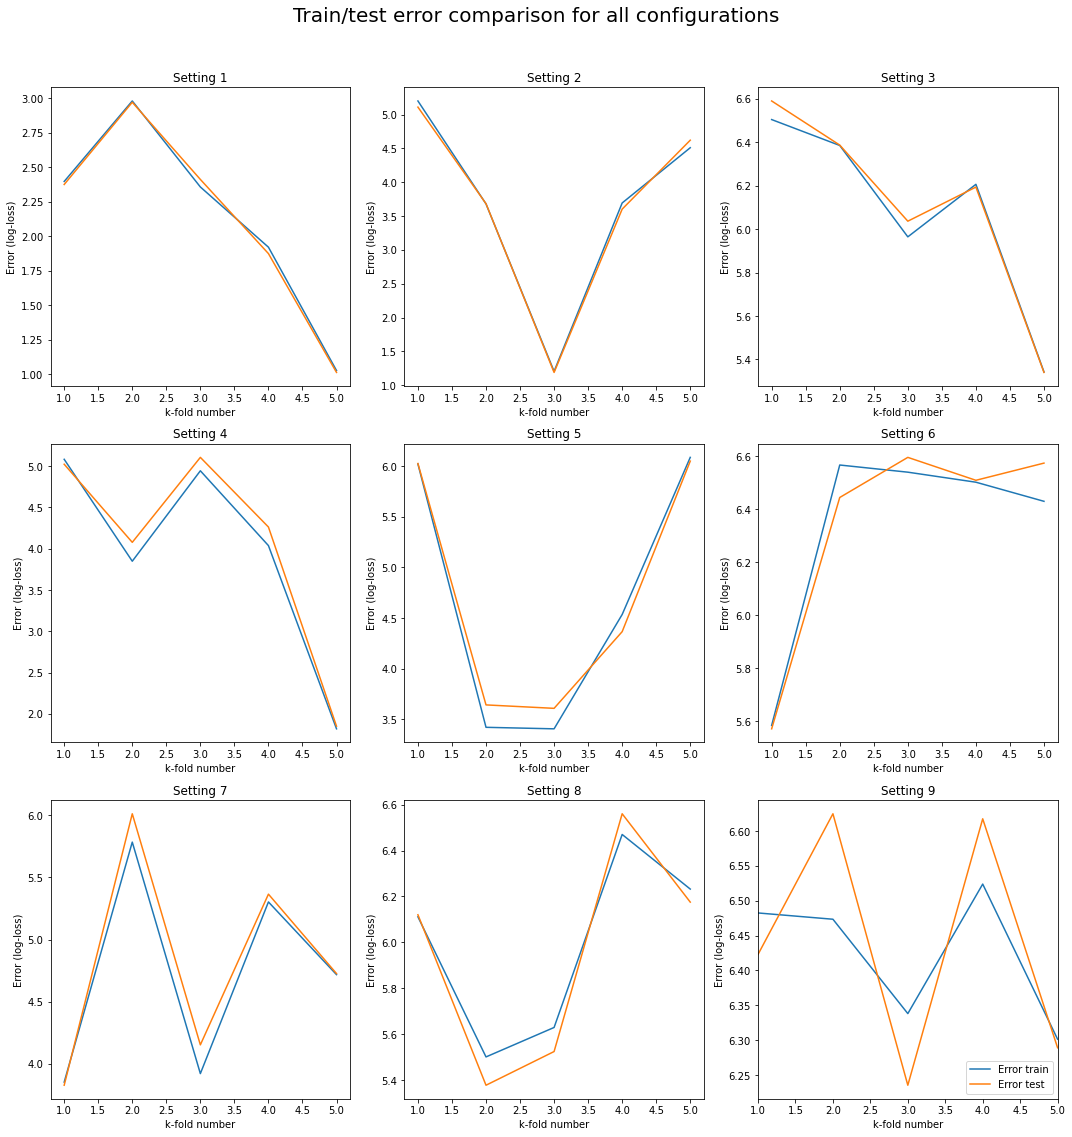

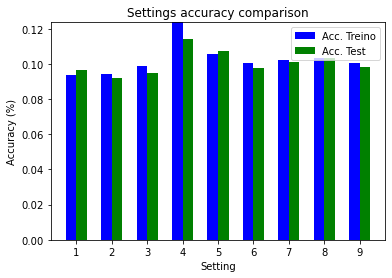

In [5]:
#Variáveis para salvar melhor resultado
max_acc, max_pre, max_rec, prec_r = [], [], [], -1
plt_train_acc, plt_test_acc = [],[]
number_conf, plt_train_error, plt_test_error = [], [], []

cont = 0
for layer_variation in units_hidden_layers:
    for rating_variation in ratings:
        acc_final, recall_final, precision_final, y_true_f, y_pred_f = [],[],[],[],[]
        plt_train = []
        train_log_loss, test_log_loss = [], []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_true = Y[train_index], Y[test_index]
            mlp = MLPClassifier(hidden_layer_sizes=(layer_variation), activation='logistic', 
                                solver='sgd', max_iter=epochs, random_state=42, learning_rate='constant', 
                                learning_rate_init=rating_variation, batch_size=1)
            #treinamento
            mlp.fit(X_train, y_train)
            #predicção nos dados de teste
            y_pred = mlp.predict(X_test)
            #cálculo do erro no treino
            train_log_loss.append((log_loss(y_train, mlp.predict_proba(X_train)))/kf.n_splits)
            #cálculo do erro no teste
            test_log_loss.append((log_loss(y_true, mlp.predict_proba(X_test)))/kf.n_splits)
            #metricas
            plt_train.append(accuracy_score(y_train, mlp.predict(X_train)))
            acc = accuracy_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
            precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
            y_true_f.append(y_true)
            y_pred_f.append(y_pred)
            acc_final.append(acc)
            recall_final.append(recall)
            precision_final.append(precision)
        plt_train_error.append(train_log_loss)
        plt_test_error.append(test_log_loss)
        cont+=1
        number_conf.append(cont)
        print(f'Config. {cont}: (UHL={layer_variation}, LR={rating_variation})')
        prec_mean = np.mean(precision_final)
        ic_acc = st.t.interval(0.9, len(acc_final) - 1, loc=np.mean(acc_final), scale=st.sem(acc_final))
        ic_recall = st.t.interval(0.9, len(recall_final) - 1, loc=np.mean(recall_final), scale=st.sem(recall_final))
        ic_pre = st.t.interval(0.9, len(precision_final) - 1, loc=prec_mean, scale=st.sem(precision_final))
        print('Mean Accuracy: [{:.4f}] ; IC: [{:.4f}, {:.4f}]'.format(np.mean(acc_final), ic_acc[0], ic_acc[1]))
        print('Mean Recall: [{:.4f}] ; IC: [{:.4f}, {:.4f}]'.format(np.mean(recall_final), ic_recall[0], ic_recall[1]))
        print('Mean Precision: [{:.4f}] ; IC: [{:.4f}, {:.4f}]\n'.format(prec_mean, ic_pre[0], ic_pre[1]))
        plt_train_acc.append(sts.mean(plt_train))
        plt_test_acc.append(sts.mean(acc_final))
        y_pred = np.concatenate(y_pred_f, axis=0)
        y_true = np.concatenate(y_true_f, axis=0)
        
        if prec_mean > prec_r:
            prec_r = prec_mean
            max_acc, max_pre, max_rec = [np.mean(acc_final),ic_acc], [prec_mean, ic_pre], [np.mean(recall_final), ic_recall]
        
acc_conc.append(max_acc)
rec_conc.append(max_rec)
pre_conc.append(max_pre)

#plot dos graficos comparativos entre os erros de treino e teste

#número de linhas e colunas da disposição dos gráficos
num_linhas, num_colunas = 3, 3
#número de folds cross validation
len_kfolds = list(range(1,kf.n_splits+1))
# Criar a figura e os subplots
fig, ax = plt.subplots(num_linhas, num_colunas, figsize=(15, 15))
fig.suptitle("Train/test error comparison for all configurations", fontsize=20,y=1.05)
cont=0
for i in range(0,num_linhas):
    for j in range(0,num_colunas):
        ax[i, j].plot(len_kfolds, plt_train_error[cont], label='Error train')
        ax[i, j].plot(len_kfolds, plt_test_error[cont], label='Error test')
        plt.xlim([min(len_kfolds), max(len_kfolds)])
        ax[i, j].set(xlabel='k-fold number', ylabel='Error (log-loss)',
               title=f'Setting {cont+1}')
        cont+=1
plt.legend(loc="lower right")
plt.tight_layout() # Ajustar os espaçamentos entre os subplots
plt.show()

# plot do gráfico de barras para comparar as acurácias
width_ = 0.3
eixo_x = np.arange(len(number_conf))
fig, ax = plt.subplots()
plt.bar(eixo_x, plt_train_acc, label='Acc. Treino',color='blue', width=width_)
plt.bar(eixo_x+width_, plt_test_acc, label='Acc. Test', color='green', width=width_)
# Definir os rótulos do eixo x
plt.xticks(eixo_x+ width_ / 2, eixo_x+1)
plt.ylim([0, max(plt_train_acc+plt_test_acc)])
ax.set(xlabel='Setting', ylabel='Accuracy (%)',
       title='Settings accuracy comparison')
plt.legend(loc="upper right")

plt.show()

### GD

O GD (Gradient Descent) é um algoritmo que possui uma ideia semelhante a do SGD, com a diferença de que os pesos são atualizado ao final de cada época, ou seja, o custo para realizar esse processo é alto, pois todas as samples precisam ser vistas antes. Além disso, como visto em aula, para alcançar a convergência esse algoritmo funciona como o "andar de um bêbado".

Com base nos resultado obtidos, pode-se dizer que o erro no treino foi um bom estimador para o erro no teste. Sendo assim, analisando todas as métricas para as configurações dadas, esse algoritmo obtive um resultado satisfatório.

Config. 1: (UHL=25, LR=0.5)
Mean Accuracy: [0.9048] ; IC: [0.8951, 0.9145]
Mean Recall: [0.9048] ; IC: [0.8939, 0.9158]
Mean Precision: [0.9038] ; IC: [0.8934, 0.9142]

Config. 2: (UHL=25, LR=1)
Mean Accuracy: [0.9084] ; IC: [0.9017, 0.9151]
Mean Recall: [0.9084] ; IC: [0.9005, 0.9164]
Mean Precision: [0.9075] ; IC: [0.9003, 0.9148]

Config. 3: (UHL=25, LR=10)
Mean Accuracy: [0.1080] ; IC: [0.0965, 0.1195]
Mean Recall: [0.1000] ; IC: [nan, nan]
Mean Precision: [0.0108] ; IC: [0.0096, 0.0120]

Config. 4: (UHL=50, LR=0.5)
Mean Accuracy: [0.9064] ; IC: [0.8974, 0.9154]
Mean Recall: [0.9065] ; IC: [0.8966, 0.9163]
Mean Precision: [0.9054] ; IC: [0.8958, 0.9150]

Config. 5: (UHL=50, LR=1)
Mean Accuracy: [0.9134] ; IC: [0.9053, 0.9215]
Mean Recall: [0.9136] ; IC: [0.9049, 0.9223]
Mean Precision: [0.9126] ; IC: [0.9043, 0.9209]

Config. 6: (UHL=50, LR=10)
Mean Accuracy: [0.1010] ; IC: [0.0885, 0.1135]
Mean Recall: [0.1000] ; IC: [nan, nan]
Mean Precision: [0.0101] ; IC: [0.0089, 0.0113]

Conf

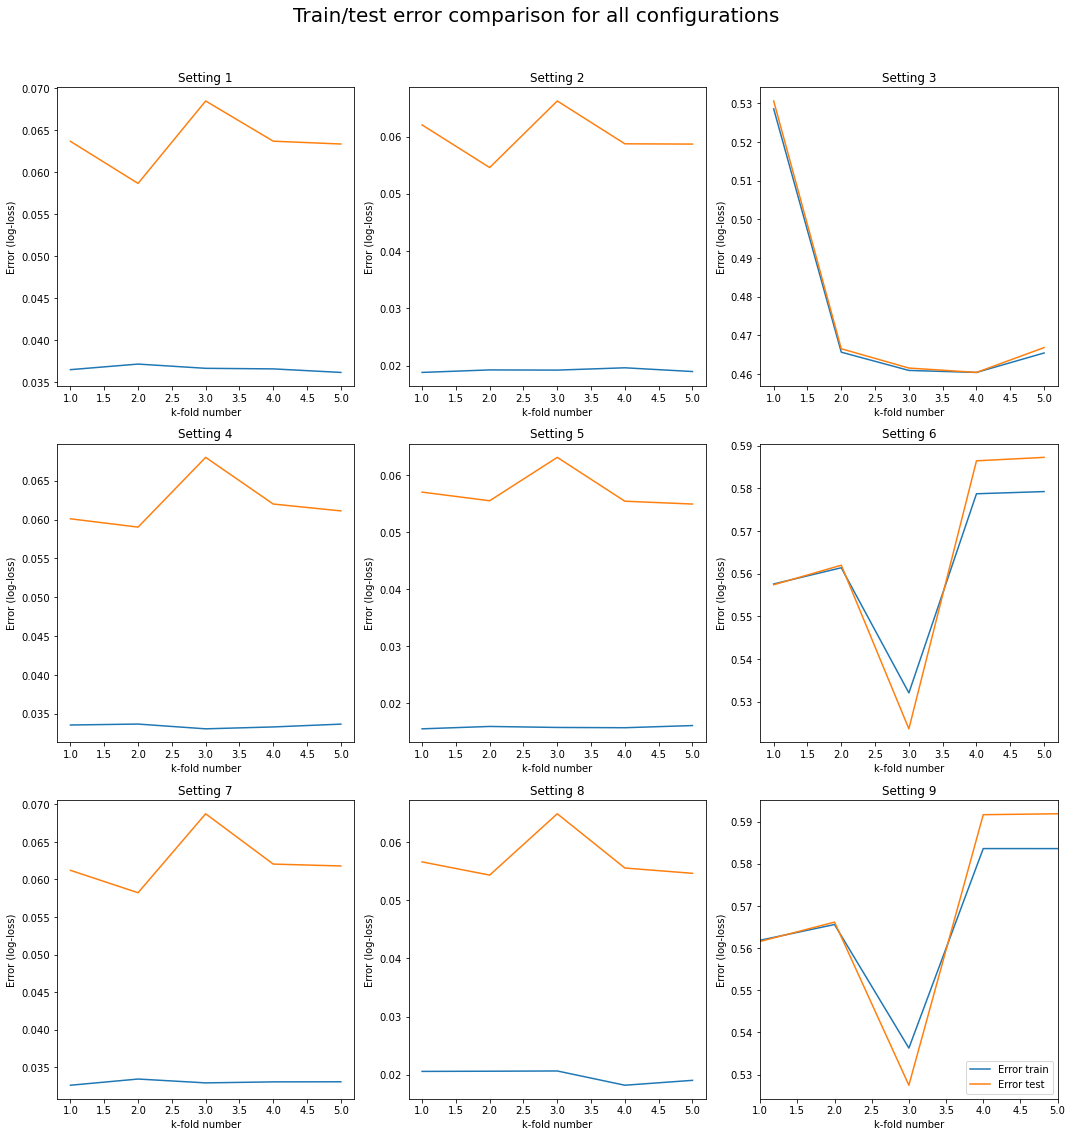

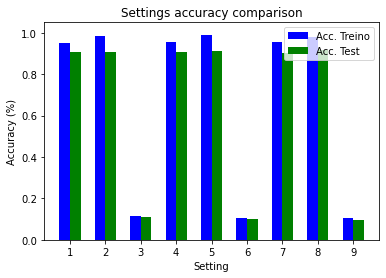

In [6]:
#Variáveis para salvar melhor resultado
max_acc, max_pre, max_rec, prec_r = [], [], [], -1
plt_train_acc, plt_test_acc = [],[]
number_conf, plt_train_error, plt_test_error = [], [], []

cont = 0
for layer_variation in units_hidden_layers:
    for rating_variation in ratings:
        acc_final, recall_final, precision_final, y_true_f, y_pred_f = [],[],[],[],[]
        plt_train = []
        train_log_loss, test_log_loss = [], []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_true = Y[train_index], Y[test_index]
            mlp = MLPClassifier(hidden_layer_sizes=(layer_variation), activation='logistic', 
                                solver='sgd', max_iter=epochs, random_state=42, learning_rate='constant', 
                                learning_rate_init=rating_variation, batch_size=len(X_train))
            #treinamento
            mlp.fit(X_train, y_train)
            #predicção nos dados de teste
            y_pred = mlp.predict(X_test)
            #cálculo do erro no treino
            train_log_loss.append((log_loss(y_train, mlp.predict_proba(X_train)))/kf.n_splits)
            #cálculo do erro no teste
            test_log_loss.append((log_loss(y_true, mlp.predict_proba(X_test)))/kf.n_splits)
            #metricas
            plt_train.append(accuracy_score(y_train, mlp.predict(X_train)))
            acc = accuracy_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
            precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
            y_true_f.append(y_true)
            y_pred_f.append(y_pred)
            acc_final.append(acc)
            recall_final.append(recall)
            precision_final.append(precision)
        plt_train_error.append(train_log_loss)
        plt_test_error.append(test_log_loss)
        cont+=1
        number_conf.append(cont)
        print(f'Config. {cont}: (UHL={layer_variation}, LR={rating_variation})')
        prec_mean = np.mean(precision_final)
        ic_acc = st.t.interval(0.9, len(acc_final) - 1, loc=np.mean(acc_final), scale=st.sem(acc_final))
        ic_recall = st.t.interval(0.9, len(recall_final) - 1, loc=np.mean(recall_final), scale=st.sem(recall_final))
        ic_pre = st.t.interval(0.9, len(precision_final) - 1, loc=prec_mean, scale=st.sem(precision_final))
        print('Mean Accuracy: [{:.4f}] ; IC: [{:.4f}, {:.4f}]'.format(np.mean(acc_final), ic_acc[0], ic_acc[1]))
        print('Mean Recall: [{:.4f}] ; IC: [{:.4f}, {:.4f}]'.format(np.mean(recall_final), ic_recall[0], ic_recall[1]))
        print('Mean Precision: [{:.4f}] ; IC: [{:.4f}, {:.4f}]\n'.format(prec_mean, ic_pre[0], ic_pre[1]))
        plt_train_acc.append(sts.mean(plt_train))
        plt_test_acc.append(sts.mean(acc_final))
        y_pred = np.concatenate(y_pred_f, axis=0)
        y_true = np.concatenate(y_true_f, axis=0)
        
        if prec_mean > prec_r:
            prec_r = prec_mean
            max_acc, max_pre, max_rec = [np.mean(acc_final),ic_acc], [prec_mean, ic_pre], [np.mean(recall_final), ic_recall]
        
acc_conc.append(max_acc)
rec_conc.append(max_rec)
pre_conc.append(max_pre)

#plot dos graficos comparativos entre os erros de treino e teste

#número de linhas e colunas da disposição dos gráficos
num_linhas, num_colunas = 3, 3
#número de folds cross validation
len_kfolds = list(range(1,kf.n_splits+1))
# Criar a figura e os subplots
fig, ax = plt.subplots(num_linhas, num_colunas, figsize=(15, 15))
fig.suptitle("Train/test error comparison for all configurations", fontsize=20,y=1.05)
cont=0
for i in range(0,num_linhas):
    for j in range(0,num_colunas):
        ax[i, j].plot(len_kfolds, plt_train_error[cont], label='Error train')
        ax[i, j].plot(len_kfolds, plt_test_error[cont], label='Error test')
        plt.xlim([min(len_kfolds), max(len_kfolds)])
        ax[i, j].set(xlabel='k-fold number', ylabel='Error (log-loss)',
               title=f'Setting {cont+1}')
        cont+=1
plt.legend(loc="lower right")
plt.tight_layout() # Ajustar os espaçamentos entre os subplots
plt.show()

# plot do gráfico de barras para comparar as acurácias
width_ = 0.3
eixo_x = np.arange(len(number_conf))
fig, ax = plt.subplots()
plt.bar(eixo_x, plt_train_acc, label='Acc. Treino',color='blue', width=width_)
plt.bar(eixo_x+width_, plt_test_acc, label='Acc. Test', color='green', width=width_)
# Definir os rótulos do eixo x
plt.xticks(eixo_x+ width_ / 2, eixo_x+1)
plt.ylim([0, 1.05])
ax.set(xlabel='Setting', ylabel='Accuracy (%)',
       title='Settings accuracy comparison')
plt.legend(loc="upper right")

plt.show()

### Mini-Batch SGD

Uma boa alternativa para os algoritmos acima pode ser o mini-batch SGD que, diferente desses, os pesos são atualizados a cada "b" samples, sem a necessidade de atualizá-los ao final de cada época (GD) ou para cada amostra (SGD).

Analisando os resultados, é possível afirmar que esse algoritmo cumpriu o que foi visto em sala e obtive bons resultados.

Config. 1: (UHL=25, LR=0.5, BS=10)
Mean Accuracy: [0.8602] ; IC: [0.8518, 0.8686]
Mean Recall: [0.8583] ; IC: [0.8456, 0.8710]
Mean Precision: [0.8654] ; IC: [0.8520, 0.8788]

Config. 2: (UHL=25, LR=1, BS=10)
Mean Accuracy: [0.7312] ; IC: [0.6603, 0.8021]
Mean Recall: [0.7262] ; IC: [0.6487, 0.8037]
Mean Precision: [0.7608] ; IC: [0.7092, 0.8124]

Config. 3: (UHL=25, LR=10, BS=10)
Mean Accuracy: [0.1076] ; IC: [0.0929, 0.1223]
Mean Recall: [0.1012] ; IC: [0.0986, 0.1038]
Mean Precision: [0.0307] ; IC: [-0.0124, 0.0737]

Config. 4: (UHL=50, LR=0.5, BS=10)
Mean Accuracy: [0.8540] ; IC: [0.8168, 0.8912]
Mean Recall: [0.8503] ; IC: [0.8074, 0.8932]
Mean Precision: [0.8662] ; IC: [0.8400, 0.8925]

Config. 5: (UHL=50, LR=1, BS=10)
Mean Accuracy: [0.7028] ; IC: [0.6457, 0.7599]
Mean Recall: [0.7005] ; IC: [0.6473, 0.7537]
Mean Precision: [0.7483] ; IC: [0.7281, 0.7684]

Config. 6: (UHL=50, LR=10, BS=10)
Mean Accuracy: [0.0904] ; IC: [0.0786, 0.1022]
Mean Recall: [0.1000] ; IC: [nan, nan]
Mean

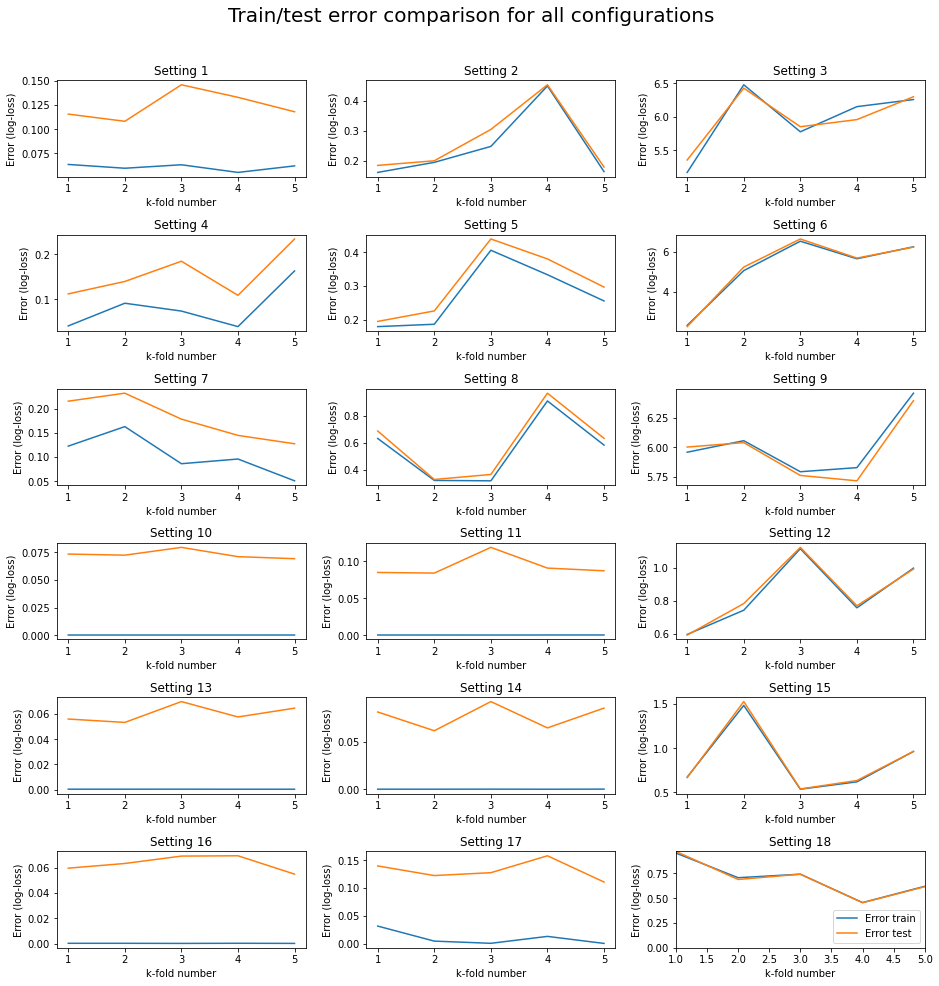

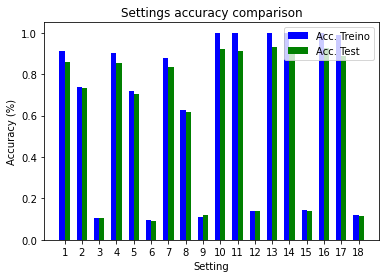

In [7]:
#Variáveis para salvar melhor resultado
max_acc, max_pre, max_rec, prec_r = [], [], [], -1
plt_train_acc, plt_test_acc = [],[]
number_conf, plt_train_error, plt_test_error = [], [], []

cont = 0
for len_batch in mini_batch:
    for layer_variation in units_hidden_layers:
        for rating_variation in ratings:
            acc_final, recall_final, precision_final, y_true_f, y_pred_f = [],[],[],[],[]
            plt_train = []
            train_log_loss, test_log_loss = [], []
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_true = Y[train_index], Y[test_index]
                mlp = MLPClassifier(hidden_layer_sizes=(layer_variation), activation='logistic', 
                                    solver='sgd', max_iter=epochs, random_state=42, learning_rate='constant', 
                                    learning_rate_init=rating_variation, batch_size=len_batch)
                #treinamento
                mlp.fit(X_train, y_train)
                #predicção nos dados de teste
                y_pred = mlp.predict(X_test)
                #cálculo do erro no treino
                train_log_loss.append((log_loss(y_train, mlp.predict_proba(X_train)))/kf.n_splits)
                #cálculo do erro no teste
                test_log_loss.append((log_loss(y_true, mlp.predict_proba(X_test)))/kf.n_splits)
                #metricas
                plt_train.append(accuracy_score(y_train, mlp.predict(X_train)))
                acc = accuracy_score(y_true, y_pred)
                recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
                precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
                y_true_f.append(y_true)
                y_pred_f.append(y_pred)
                acc_final.append(acc)
                recall_final.append(recall)
                precision_final.append(precision)
            plt_train_error.append(train_log_loss)
            plt_test_error.append(test_log_loss)
            cont+=1
            number_conf.append(cont)
            print(f'Config. {cont}: (UHL={layer_variation}, LR={rating_variation}, BS={len_batch})')
            prec_mean = np.mean(precision_final)
            ic_acc = st.t.interval(0.9, len(acc_final) - 1, loc=np.mean(acc_final), scale=st.sem(acc_final))
            ic_recall = st.t.interval(0.9, len(recall_final) - 1, loc=np.mean(recall_final), scale=st.sem(recall_final))
            ic_pre = st.t.interval(0.9, len(precision_final) - 1, loc=prec_mean, scale=st.sem(precision_final))
            print('Mean Accuracy: [{:.4f}] ; IC: [{:.4f}, {:.4f}]'.format(np.mean(acc_final), ic_acc[0], ic_acc[1]))
            print('Mean Recall: [{:.4f}] ; IC: [{:.4f}, {:.4f}]'.format(np.mean(recall_final), ic_recall[0], ic_recall[1]))
            print('Mean Precision: [{:.4f}] ; IC: [{:.4f}, {:.4f}]\n'.format(prec_mean, ic_pre[0], ic_pre[1]))
            plt_train_acc.append(sts.mean(plt_train))
            plt_test_acc.append(sts.mean(acc_final))
            y_pred = np.concatenate(y_pred_f, axis=0)
            y_true = np.concatenate(y_true_f, axis=0)

            if prec_mean > prec_r:
                prec_r = prec_mean
                max_acc, max_pre, max_rec = [np.mean(acc_final),ic_acc], [prec_mean, ic_pre], [np.mean(recall_final), ic_recall]
        
acc_conc.append(max_acc)
rec_conc.append(max_rec)
pre_conc.append(max_pre)

#plot dos graficos comparativos entre os erros de treino e teste

#número de linhas e colunas da disposição dos gráficos
num_linhas, num_colunas = 6, 3
#número de folds cross validation
len_kfolds = list(range(1,kf.n_splits+1))
# Criar a figura e os subplots
fig, ax = plt.subplots(num_linhas, num_colunas, figsize=(13, 13))
fig.suptitle("Train/test error comparison for all configurations", fontsize=20,y=1.05)
cont=0
for i in range(0,num_linhas):
    for j in range(0,num_colunas):
        ax[i, j].plot(len_kfolds, plt_train_error[cont], label='Error train')
        ax[i, j].plot(len_kfolds, plt_test_error[cont], label='Error test')
        plt.xlim([min(len_kfolds), max(len_kfolds)])
        plt.ylim([0, max(plt_train_error[cont]+plt_test_error[cont])])
        ax[i, j].set(xlabel='k-fold number', ylabel='Error (log-loss)',
               title=f'Setting {cont+1}')
        cont+=1
        
plt.legend(loc="lower right")
plt.tight_layout() # Ajustar os espaçamentos entre os subplots
plt.show()

# plot do gráfico de barras para comparar as acurácias
width_ = 0.3
eixo_x = np.arange(len(number_conf))
fig, ax = plt.subplots()
plt.bar(eixo_x, plt_train_acc, label='Acc. Treino',color='blue', width=width_)
plt.bar(eixo_x+width_, plt_test_acc, label='Acc. Test', color='green', width=width_)
# Definir os rótulos do eixo x
plt.xticks(eixo_x+ width_ / 2, eixo_x+1)
plt.ylim([0, 1.05])
ax.set(xlabel='Setting', ylabel='Accuracy (%)',
       title='Settings accuracy comparison')
plt.legend(loc="upper right")

plt.show()

### Comparação Final

Gerar métricas e gráfico de comparação entre os melhores valores de cada algoritmo.

SGD
Mean Accuracy[0.1140] IC [0.0715, 0.1565]
Mean Recall[0.1186] IC [0.0789, 0.1583]
Mean Precision[0.0212] IC [-0.0039, 0.0464]

GD
Mean Accuracy[0.9146] IC [0.9098, 0.9194]
Mean Recall[0.9148] IC [0.9096, 0.9201]
Mean Precision[0.9134] IC [0.9092, 0.9176]

Mini-batch SGD
Mean Accuracy[0.9314] IC [0.9257, 0.9371]
Mean Recall[0.9316] IC [0.9250, 0.9382]
Mean Precision[0.9303] IC [0.9234, 0.9373]



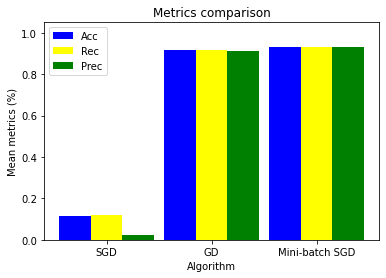

In [8]:
acc, rec, prec = [], [], []
for i in range(0, len(algorithms)):
    print(algorithms[i])
    print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(acc_conc[i][0], acc_conc[i][1][0], acc_conc[i][1][1]))
    print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(rec_conc[i][0], rec_conc[i][1][0], rec_conc[i][1][1]))
    print('Mean Precision[{:.4f}] IC [{:.4f}, {:.4f}]\n'.format(pre_conc[i][0], pre_conc[i][1][0], pre_conc[i][1][1]))
    acc.append(acc_conc[i][0])
    rec.append(rec_conc[i][0])
    prec.append(pre_conc[i][0])
    
width_ = 0.3
eixo_x = np.arange(len(acc))
fig, ax = plt.subplots()

plt.bar(eixo_x, acc, label='Acc', color='blue', width=width_)
plt.bar(eixo_x+width_, rec, label='Rec', color='yellow', width=width_)
plt.bar(eixo_x+width_+width_, prec, label='Prec', color='green', width=width_)

# Definir os rótulos do eixo x
ax.set_xticks(eixo_x + width_)
ax.set_xticklabels(algorithms)

plt.ylim([0, 1.05])
ax.set(xlabel='Algorithm', ylabel='Mean metrics (%)', title='Metrics comparison')
plt.legend(loc="upper left")

plt.show()

### Análise e Comentários finais

Como abordado e visto durante o trabalho e a matéria, é importante destacar que a escolha dos hiperparâmetros e algoritmos de atualização de cálculo de gradiente para treinar uma rede pode ter grande influência no resultado final. 

Com base nas métricas de acurácia, precisão e seus intervalos de confiança, foi selecionado o melhor algoritmo de cálculo de gradiente para as configurações dadas. Os melhores algoritmos foram comparados no gáfico anterior,  utilizando a média das 5 folds. O intervalo de confiança considerou uma distribuição padrão da média das métricas, utilizou probabilidade de noventa por cento.

O melhor algoritmo foi o Mini-batch SGD, devido aos valores de acurácia, recall e precisão melhores que os outros. Os valores estão muito próximos entre o GD e o Mini-batch SGD, mas levando em conta o intervalo de confiança, essa superioridade é confirmada.

É válido destacar que quando a taxa de aprendizado valia 10, de modo geral, todos os 3 algoritmos obtiverem os piores resultados. Porém, o SGD teve um resultado muito abaixo da média se comparado aos outros, como visto acima.Assim, com base nos resultados e análises/pesquisas feitas, chega-se a conclusão de que esse comportamento deve-se a uma taxa de aprendizado alta (0.5, 1 e 10) para testar esse algoritmo, gerando péssimos resultados.